# Assignment 2 - Impact of Bitcoin (BTC) tweets sentiment on returns
## Alkan Pamukchu, Andres Brito, Kristján Eldur, Parth Bansal, Yan Le

In [36]:
# !pip install --user --upgrade
# !pip install --user --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
# !pip install langid
# !pip install vaderSentiment

In [37]:
# Machine Learning packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
color='c'
import seaborn as sns

In [38]:
# Twitter scraping and preprocessing packages
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import twint
import nest_asyncio
import datetime as dt
import langid
pd.options.display.max_columns = 100
nest_asyncio.apply()

### Twitter scraping and tweet preprocessing

In [3]:
# Configure the twitter scraper
c = twint.Config()
c.Search = "Bitcoin' OR 'BTC"
c.Since = '2013-09-17'
c.Store_json = True
c.Output = "tweet_data.json"
c.Hide_output = True
c.Min_likes = 500
c.Min_retweets = 200

# Run
twint.run.Search(c)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [4]:
# load the tweet data into a DataFrame
data = pd.read_json("../Assignment 2/tweet_data.json", lines = True)
data.to_csv('Tweet_Data_Raw.csv')
data.shape

(14908, 36)

In [5]:
# Visualize the data and the first tweet
data.head(3)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1400459812220018695,1400459812220018688,2021-06-03 15:30:13 GMT Summer Time,2021-06-03,15:30:13,100,1012436626776174592,airdropdet,AirdropDetective,,🔍 New #Airdrop: Bullperks 💲 Total Reward: Up ...,en,[],"[http://t.me/BullperksBot, https://youtu.be/KP...",[https://pbs.twimg.com/media/E29tqM6VoAkLbeO.jpg],294,3566,3442,"[airdrop, airdrops, bitcoin, crypto, airdropde...",[],https://twitter.com/AirdropDet/status/14004598...,False,,1,https://pbs.twimg.com/media/E29tqM6VoAkLbeO.jpg,,,,,,,[],,,,
1,1400443266428977155,1400443266428977152,2021-06-03 14:24:28 GMT Summer Time,2021-06-03,14:24:28,100,1095590506225111040,tokensjil,CryptoTv,,📣 CryptoTv @Airdrop is live! 🏆 Reward for Tas...,en,"[{'screen_name': 'airdrop', 'name': 'airdrop',...",[http://t.me/CTVairdropbot],[https://pbs.twimg.com/media/E29fuo9X0AcF1K0.jpg],596,1129,1889,"[airdrop, bitcoin, ethereum, crypto, crypto, c...",[],https://twitter.com/TokensJil/status/140044326...,False,,1,https://pbs.twimg.com/media/E29fuo9X0AcF1K0.jpg,,,,,,,[],,,,
2,1400437984562868228,1400437984562868224,2021-06-03 14:03:29 GMT Summer Time,2021-06-03,14:03:29,100,240133655,bitcoinbro303,Bitcoin Bro 💥,,$50 to 1 person who RT's and follows @Desert_F...,en,"[{'screen_name': 'desert_finance', 'name': 'de...",[],[],558,1422,624,[],[],https://twitter.com/BitcoinBro303/status/14004...,False,,0,,,,,,,,[],,,,


In [6]:
data['tweet'][0]

'🔍 New #Airdrop: Bullperks  💲 Total Reward: Up to 1 USDT + 1500 USDT referrer pool  🔴 Start the airdrop bot:  https://t.co/AzhntFSRAJ  🔘 Do the tasks on the bot &amp; submit your data  🔘 Details:  https://t.co/7tqPRwKiNP  #Airdrops #Bitcoin #crypto #AirdropDetective #NFT #Bullperks  https://t.co/Yi16Hlaksj'

In [7]:
# Use only english tweets and create a tweet dataframe with date and tweets
tweets = data[data['language']=='en']
tweet_data = pd.DataFrame(tweets, columns = (['date', 'tweet']))
tweet_data

,date,tweet
0,2021-06-03,🔍 New #Airdrop: Bullperks 💲 Total Reward: Up ...
1,2021-06-03,📣 CryptoTv @Airdrop is live! 🏆 Reward for Tas...
2,2021-06-03,$50 to 1 person who RT's and follows @Desert_F...
3,2021-06-03,ALERT: Grayscale Adds Half a Billion in #Bitco...
4,2021-06-03,"A group of developers, https://t.co/WJQEkXy2a..."
...,...,...
14903,2014-02-26,What idiot named it Bitcoin and not Cache money
14904,2014-02-26,"In lieu of Bitcoin, I’ve stuck to flushing $10..."
14905,2014-02-07,"Apple removing the Bitcoin app after 120,000 d..."
14906,2013-12-23,"in Jesus time, rendering unto Caeser could tak..."


In [8]:
# Preprocess the tweets in tweet_data
porter = PorterStemmer()
def mypreprocess(text):
    # text is one tweet of the corpus
    # lowercase the tweet
    text =   text.lower()
    # remove irrelevant numbers, punctuation and links
    text =   re.sub(r'[^a-z]+',' ',text)
    text =   re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text =   re.sub(r'((http)\S+)','',text)
    # tokenize the words
    token1 = word_tokenize(text)
    # stemming transformation
    token2 = [porter.stem(t) for t in token1]
    
    return ' '.join(token2)

tweet_data['tweet'] = tweet_data['tweet'].apply(lambda text: mypreprocess(text))
tweet_data.sample(3)

,date,tweet
10085,2019-08-14,bitcoin s price could fall from today s price ...
4088,2021-03-11,break white hous set up coinbas account to acc...
7237,2020-12-12,y l n e d d u s then gradual bitcoin


In [12]:
# Valence Aware Dictionary and sEntiment Reasoner (VADER) is a lexicon and 
# rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiment = []
for text in tweet_data['tweet']:
    vs = analyzer.polarity_scores(text)
    sentiment.append(vs['compound'])

tweet_data['sentiment'] = sentiment

In [13]:
tweet_data

,date,tweet,sentiment
0,2021-06-03,new airdrop bullperk total reward up to usdt u...,0.6115
1,2021-06-03,cryptotv airdrop is live reward for task up to...,0.8126
2,2021-06-03,to person who rt s and follow desert financ rt...,0.0000
3,2021-06-03,alert grayscal add half a billion in bitcoin a...,0.2960
4,2021-06-03,a group of develop t co wjqekxi am just comple...,0.0258
...,...,...,...
14903,2014-02-26,what idiot name it bitcoin and not cach money,-0.5106
14904,2014-02-26,in lieu of bitcoin i ve stuck to flush bill do...,-0.1280
14905,2014-02-07,appl remov the bitcoin app after download is j...,-0.7783
14906,2013-12-23,in jesu time render unto caeser could take up ...,0.3612


In [14]:
tweet_data['tweet'][3]

'alert grayscal add half a billion in bitcoin and other crypto in just one day'

In [15]:
tweet_data['sentiment'][3]

0.296

# Model creation

#### Loading in data and creating technical variables

In [39]:
data = pd.read_csv("btc_data.csv")
data['Target'] = ((data.returns + 1).rolling(5, min_periods = 5).agg(lambda x : x.prod()) - 1).shift(-5)
data.loc[data.Target>=0.025,"Target"] = 1
data.loc[data.Target<=-0.025,"Target"] = -1
data.loc[(data.Target>=-0.025) & (data.Target<=0.025) ,"Target"] = 0

In [40]:
n=5
data['days_volume_sum'] = np.zeros(shape=(len(data),1))
for i in range(2, len(data)):
    data['days_volume_sum'][i] = data['Volume'][i-n+1:i+1].sum()
    
data['days_low_price'] = np.zeros(shape=(len(data),1))
for i in range(2, len(data)):
    data['days_low_price'][i] = data["Low"][i-n+1:i+1].min()

data['days_high_price'] = np.zeros(shape=(len(data),1))
for i in range(2, len(data)):
    data['days_high_price'][i] = data["High"][i-n+1:i+1].max()

data["VWAP"] = ((data['days_high_price']+data['days_low_price']+data["Close"])/3) * data['days_volume_sum']
data["volume_price"] = data['Close'].pct_change(n)*data['days_volume_sum']
data.drop(['days_volume_sum', 'days_low_price','days_high_price'], axis=1, inplace=True)

<ipython-input-40-a19065cb3cf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_volume_sum'][i] = data['Volume'][i-n+1:i+1].sum()
<ipython-input-40-a19065cb3cf8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_low_price'][i] = data["Low"][i-n+1:i+1].min()
<ipython-input-40-a19065cb3cf8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_high_price'][i] = data["High"][i-n+1:i+1].max()


In [41]:
def slow_stochastic_oscillator(df, open_price, high_price, low_price, close_price):
    df["14-high"] = df[high_price].rolling(14, min_periods=1).max()
    df["14-low"] = df[low_price].rolling(14, min_periods=1).min()
    df['%K']= (df[close_price] - df['14-low'])*100/(df['14-high'] - df['14-low'])
    df['%D'] = df['%K'].rolling(3, min_periods=1).mean()
    df.drop(["14-high", "14-low",'%K'], axis=1, inplace=True)
slow_stochastic_oscillator(data, 'Open', 'High', 'Low', 'Close')

In [42]:
from scipy.stats import skew 
def skewness(df, price, n=30):
    df['skewness'] = price.pct_change().rolling(window=n).skew()
skewness(data, data['Close'], n=30)

In [43]:
def volatility(df, price, n=30):
    df['volatility'] = price.pct_change().rolling(window=n).std()   
volatility(data, data['Close'])

In [44]:
def momentum(returns, price):
    returns['momentum_20_50'] = np.zeros(shape=(len(price),1))
    returns['momentum_8_20'] = np.zeros(shape=(len(price),1))
    for i in range(49, len(price)):
        if price[i-19:i+1].mean() > price[i-49:i+1].mean():
            returns['momentum_20_50'][i] = 1
        if price[i-19:i+1].mean() < price[i-49:i+1].mean():
            returns['momentum_20_50'][i] = 0
        if price[i-7:i+1].mean() > price[i-19:i+1].mean():
            returns['momentum_8_20'][i] = 1
        if price[i-7:i+1].mean() < price[i-19:i+1].mean():
            returns['momentum_8_20'][i] = 0
            
momentum(data, data['Close'])

<ipython-input-44-a711712abb64>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['momentum_20_50'][i] = 1
<ipython-input-44-a711712abb64>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['momentum_8_20'][i] = 1
<ipython-input-44-a711712abb64>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['momentum_8_20'][i] = 0
<ipython-input-44-a711712abb64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [45]:
def top_bottom_distance(returns, price, n=30):
    returns['dist_to_bottom'] = np.zeros(shape=(len(price),1))
    returns['dist_to_top'] = np.zeros(shape=(len(price),1))
    
    for i in range(n, len(price)):
        returns['dist_to_bottom'][i] = (price[i]- price[i-n+1:i+1].min())/price[i]
        returns['dist_to_top'][i] = (price[i-n+1:i+1].max()- price[i])/price[i]
        
top_bottom_distance(data, data['Close'])

<ipython-input-45-585187a5436a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['dist_to_bottom'][i] = (price[i]- price[i-n+1:i+1].min())/price[i]
<ipython-input-45-585187a5436a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['dist_to_top'][i] = (price[i-n+1:i+1].max()- price[i])/price[i]


In [46]:
price = data['Close']
data['rsi_change'] = np.zeros(shape=(len(price),1))
data['macd_rsi'] = np.zeros(shape=(len(price),1))
    
    
data['rsi_change'] = data['RSI'].pct_change(5)
data['macd_rsi'] = np.zeros(shape=(len(price),1))
for i in range(25, len(price)):
    if data['RSI'][i-11:i+1].mean() > data['RSI'][i-25:i+1].mean():
        data['macd_rsi'][i] = 1
    if data['RSI'][i-11:i+1].mean() < data['RSI'][i-22:i+1].mean():
        data['macd_rsi'][i] = 0

<ipython-input-46-795f488a016e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_rsi'][i] = 1
<ipython-input-46-795f488a016e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_rsi'][i] = 0


In [47]:
def volume_price_actions(df, close, volume, n=5):
    df['{}dayvolume_price'.format(n)] = df[volume].pct_change(n)* df[close].pct_change(n) 
volume_price_actions(data, 'Close', 'Volume')

In [48]:
def distance_to_top_and_bottom(df, price):
    bollinger_up = data['BollingerUp']
    bollinger_down = data['BollingerDn']
    df['dist_top_band']= (bollinger_up - price)/price
    df['dist_bottom_band']= (price - bollinger_down)/price
        
distance_to_top_and_bottom(data, data['Close'])

In [49]:
def difference_from_mean(df, price, n=30):
    df['difference_from_mean'] = np.zeros(shape=(len(price),1))
    for i in range(n, len(price)):
        df['difference_from_mean'][i] = (price[i] - price[i-n:i].mean())/price[i-n:i].mean()
difference_from_mean(data, data['Close'])

<ipython-input-49-4f6e9c8cd297>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference_from_mean'][i] = (price[i] - price[i-n:i].mean())/price[i-n:i].mean()


# NN Tuning

In [50]:
sentiment_data = pd.read_csv("Tweet_Data_Sentiment.csv").drop(columns=["Unnamed: 0"])
sentiment = pd.DataFrame(sentiment_data.groupby('date')["sentiment"].mean())
sentiment = sentiment.reset_index()
sentiment.columns.values[0] = "Date"
data = data.merge(sentiment, how= "left", on = "Date")
tscv = TimeSeriesSplit(n_splits=3)

data.dropna(inplace=True)
X = data.drop(columns=["Date","Target","Close"])
Y = data.Target
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
print(Counter(Y_train))
Y_train = to_categorical(Y_train,3)
Y_test = to_categorical(Y_test,3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
X_train.shape,Y_train.shape

Counter({1.0: 369, -1.0: 320, 0.0: 273})


((962, 44), (962, 3))

### Sentiment model

In [24]:
param_grid = { 'layers':[(128,64), (32,16), (64,32), (128, "dropout", 32), 
                      (512,256,128),(256,128,64),(512,"dropout",128,64),
                      (512,256,"dropout",64), (1024,512,256,128),
                      (512,256,128,64), (256,128,64,32),(1024,512,"dropout",64,32),
                      (1024,512,256,"dropout",64)],
              'dropout_rate': [0.1,0.33,0.5],
              'activation_function': ["sigmoid","tanh","relu"],
              'output_function':['softmax'],
              'optimizer' : ['SGD', 'RMSprop', 'Adam'],
              'learning_rate':[0.001,0.01,0.0001]
            }

def create_model(layers=[],dropout_rate = 0.1, learning_rate = 0.001,
                 activation_function = "relu", output_function = "softmax",
                 optimizer = "Adam"):
    
    model = Sequential()
    model.add(Dense(layers[0], input_dim = 44, activation=activation_function))
    for layer in layers[1:]:
        if layer == "dropout":
            model.add(Dropout(dropout_rate))
        else:
            model.add(Dense(layer,activation=activation_function))
    model.add(Dense(3,activation=output_function))
    
    if optimizer == "Adam":
        opt = optimizers.Adam(learning_rate = learning_rate)
    elif optimizer == "SGD":
        opt = optimizers.SGD(learning_rate = learning_rate)
    else:
        opt = optimizers.RMSprop(learning_rate = learning_rate)
    
    model.compile(loss='categorical_crossentropy' , optimizer=opt, metrics=["accuracy"])
    
    return model
    

In [25]:
model = KerasClassifier(build_fn = create_model, verbose = 1, epochs = 100, batch_size = 32)
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = tscv)
grid_result = grid.fit(X_train,Y_train)

Epoch 1/100
31/31 [==============================] - 0s 613us/step - loss: 1.2728 - accuracy: 0.2817
Epoch 2/100
31/31 [==============================] - 0s 581us/step - loss: 1.2618 - accuracy: 0.2869
Epoch 3/100
31/31 [==============================] - 0s 581us/step - loss: 1.2524 - accuracy: 0.2838
Epoch 4/100
31/31 [==============================] - 0s 549us/step - loss: 1.2430 - accuracy: 0.2921
Epoch 5/100
31/31 [==============================] - 0s 581us/step - loss: 1.2341 - accuracy: 0.2911
Epoch 6/100
31/31 [==============================] - 0s 581us/step - loss: 1.2254 - accuracy: 0.2869
Epoch 7/100
31/31 [==============================] - 0s 549us/step - loss: 1.2177 - accuracy: 0.2869
Epoch 8/100
31/31 [==============================] - 0s 581us/step - loss: 1.2105 - accuracy: 0.2838
Epoch 9/100
31/31 [==============================] - 0s 549us/step - loss: 1.2036 - accuracy: 0.2890
Epoch 10/100
31/31 [==============================] - 0s 581us/step - loss: 1.1971 - accura

### Normal model

In [62]:
param_grid = { 'layers':[(128,64), (32,16), (64,32), (128, "dropout", 32), 
                      (512,256,128),(256,128,64),(512,"dropout",128,64),
                      (512,256,"dropout",64), (1024,512,256,128),
                      (512,256,128,64), (256,128,64,32),(1024,512,"dropout",64,32),
                      (1024,512,256,"dropout",64)],
              'dropout_rate': [0.1,0.33,0.5],
              'activation_function': ["sigmoid","tanh","relu"],
              'output_function':['softmax'],
              'optimizer' : ['SGD', 'RMSprop', 'Adam'],
              'learning_rate':[0.001,0.01,0.0001]
            }

def create_model(layers=[],dropout_rate = 0.1, learning_rate = 0.001,
                 activation_function = "relu", output_function = "softmax",
                 optimizer = "Adam"):
    
    model = Sequential()
    model.add(Dense(layers[0], input_dim = 43, activation=activation_function))
    for layer in layers[1:]:
        if layer == "dropout":
            model.add(Dropout(dropout_rate))
        else:
            model.add(Dense(layer,activation=activation_function))
    model.add(Dense(3,activation=output_function))
    
    if optimizer == "Adam":
        opt = optimizers.Adam(learning_rate = learning_rate)
    elif optimizer == "SGD":
        opt = optimizers.SGD(learning_rate = learning_rate)
    else:
        opt = optimizers.RMSprop(learning_rate = learning_rate)
    
    model.compile(loss='categorical_crossentropy' , optimizer=opt, metrics=["accuracy"])
    
    return model
    

In [20]:
X = data.drop(columns=["Date","Target","Close","sentiment"])
Y = data.Target
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
print(Counter(Y_train))
Y_train = to_categorical(Y_train,3)
Y_test = to_categorical(Y_test,3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
X_train.shape,Y_train.shape

Counter({1.0: 369, -1.0: 320, 0.0: 273})


((962, 43), (962, 3))

In [63]:
model = KerasClassifier(build_fn = create_model, verbose = 1, epochs = 100, batch_size = 32)
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = tscv)
grid_result_normal = grid.fit(X_train,Y_train)

Epoch 1/100
31/31 [==============================] - 0s 484us/step - loss: 1.2129 - accuracy: 0.3015
Epoch 2/100
31/31 [==============================] - 0s 452us/step - loss: 1.2105 - accuracy: 0.3015
Epoch 3/100
31/31 [==============================] - 0s 420us/step - loss: 1.2082 - accuracy: 0.3067
Epoch 4/100
31/31 [==============================] - 0s 387us/step - loss: 1.2061 - accuracy: 0.3087
Epoch 5/100
31/31 [==============================] - 0s 743us/step - loss: 1.2038 - accuracy: 0.3119
Epoch 6/100
31/31 [==============================] - 0s 387us/step - loss: 1.2019 - accuracy: 0.3129
Epoch 7/100
31/31 [==============================] - 0s 387us/step - loss: 1.1997 - accuracy: 0.3098
Epoch 8/100
31/31 [==============================] - 0s 420us/step - loss: 1.1976 - accuracy: 0.3098
Epoch 9/100
31/31 [==============================] - 0s 387us/step - loss: 1.1957 - accuracy: 0.3119
Epoch 10/100
31/31 [==============================] - 0s 387us/step - loss: 1.1939 - accura

Epoch 81/100
31/31 [==============================] - 0s 387us/step - loss: 1.1248 - accuracy: 0.3378
Epoch 82/100
31/31 [==============================] - 0s 387us/step - loss: 1.1242 - accuracy: 0.3378
Epoch 83/100
31/31 [==============================] - 0s 387us/step - loss: 1.1237 - accuracy: 0.3368
Epoch 84/100
31/31 [==============================] - 0s 387us/step - loss: 1.1233 - accuracy: 0.3378
Epoch 85/100
31/31 [==============================] - 0s 387us/step - loss: 1.1229 - accuracy: 0.3378
Epoch 86/100
31/31 [==============================] - 0s 420us/step - loss: 1.1224 - accuracy: 0.3389
Epoch 87/100
31/31 [==============================] - 0s 387us/step - loss: 1.1220 - accuracy: 0.3410
Epoch 88/100
31/31 [==============================] - 0s 387us/step - loss: 1.1215 - accuracy: 0.3420
Epoch 89/100
31/31 [==============================] - 0s 387us/step - loss: 1.1210 - accuracy: 0.3451
Epoch 90/100
31/31 [==============================] - 0s 387us/step - loss: 1.1206

Evaluate results sentiment

In [35]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.429167 using {'activation_function': 'tanh', 'dropout_rate': 0.5, 'layers': (256, 128, 64), 'learning_rate': 0.0001, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.323611 (0.020507) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.331944 (0.062392) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'output_function': 'softmax'}
0.323611 (0.069832) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'Adam', 'output_function': 'softmax'}
0.327778 (0.046935) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.01, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.348611 (0.020787) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_

Evaluate results normal

In [64]:
print("Best: %f using %s" % (grid_result_normal.best_score_, grid_result_normal.best_params_))
means = grid_result_normal.cv_results_['mean_test_score']
stds = grid_result_normal.cv_results_['std_test_score']
params = grid_result_normal.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.425000 using {'activation_function': 'relu', 'dropout_rate': 0.33, 'layers': (64, 32), 'learning_rate': 0.0001, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.327778 (0.015713) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.334722 (0.063859) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'output_function': 'softmax'}
0.327778 (0.073151) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.001, 'optimizer': 'Adam', 'output_function': 'softmax'}
0.327778 (0.040588) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate': 0.01, 'optimizer': 'SGD', 'output_function': 'softmax'}
0.333333 (0.030619) with: {'activation_function': 'sigmoid', 'dropout_rate': 0.1, 'layers': (128, 64), 'learning_rate'

#### Evaluate models

Best: 0.429167 using {'activation_function': 'tanh', 'dropout_rate': 0.5, 'layers': (256, 128, 64), 'learning_rate': 0.0001, 'optimizer': 'SGD', 'output_function': 'softmax'}

In [51]:
def best_model_sentiment(X,Y, window):
    
    #Data formatting
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
    Y_train = to_categorical(Y_train,3)
    Y_test = to_categorical(Y_test,3)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.transform(X_test)
    
    #Create model
    model = Sequential()
    model.add(Dense(256, input_dim = X.shape[1], activation='tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(3,activation='softmax'))

    opt = optimizers.SGD(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy' , optimizer=opt, metrics=["accuracy"])
    
    preds = []
    model.fit(X_train, Y_train, batch_size = 32, epochs = 100)
    preds.append(model.predict(X_test[:window]))
    while True:

        X_train = np.concatenate((X_train,X_test[:window]))
        Y_train = np.concatenate((Y_train,Y_test[:window]))
        X_test = X_test[window:,]
        Y_test = Y_test[window:,]
        print(len(np.concatenate(preds).ravel().tolist()),len(X_train),len(X_test))
        model.fit(X_train, Y_train)
        try:
            preds.append(model.predict(X_test[:window]))
        except:
            if len(X_test)>0:
                preds.append(model.predict(X_test))
            break
    return preds

Best: 0.425000 using {'activation_function': 'relu', 'dropout_rate': 0.33, 'layers': (64, 32), 'learning_rate': 0.0001, 'optimizer': 'SGD', 'output_function': 'softmax'}

In [52]:
def best_model_normal(X,Y, window):
    
    #Data formatting
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
    Y_train = to_categorical(Y_train,3)
    Y_test = to_categorical(Y_test,3)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.transform(X_test)
    
    #Create model
    model = Sequential()
    model.add(Dense(64, input_dim = X.shape[1], activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    opt = optimizers.SGD(learning_rate = 0.001)
    model.compile(loss='categorical_crossentropy' , optimizer=opt, metrics=["accuracy"])
    
    preds = []
    model.fit(X_train, Y_train, batch_size = 32, epochs = 100)
    preds.append(model.predict(X_test[:window]))
    while True:

        X_train = np.concatenate((X_train,X_test[:window]))
        Y_train = np.concatenate((Y_train,Y_test[:window]))
        X_test = X_test[window:,]
        Y_test = Y_test[window:,]
        print(len(np.concatenate(preds).ravel().tolist()),len(X_train),len(X_test))
        model.fit(X_train, Y_train)
        try:
            preds.append(model.predict(X_test[:window]))
        except:
            if len(X_test)>0:
                preds.append(model.predict(X_test))
            break
    return preds

In [82]:
preds_norm = best_model_normal(data.drop(columns=["Date","Target","sentiment"]),data.Target,50)
preds_sentiment = best_model_sentiment(data.drop(columns=["Date","Target"]),data.Target,50)
preds_norm = np.vstack(preds_norm)
preds_sentiment = np.vstack(preds_sentiment)

Epoch 1/100
31/31 [==============================] - 0s 484us/step - loss: 1.1772 - accuracy: 0.3638
Epoch 2/100
31/31 [==============================] - 0s 452us/step - loss: 1.1595 - accuracy: 0.3825
Epoch 3/100
31/31 [==============================] - 0s 452us/step - loss: 1.1455 - accuracy: 0.3898
Epoch 4/100
31/31 [==============================] - 0s 420us/step - loss: 1.1330 - accuracy: 0.3909
Epoch 5/100
31/31 [==============================] - 0s 420us/step - loss: 1.1245 - accuracy: 0.3929
Epoch 6/100
31/31 [==============================] - 0s 420us/step - loss: 1.1159 - accuracy: 0.3929
Epoch 7/100
31/31 [==============================] - 0s 420us/step - loss: 1.1096 - accuracy: 0.3971
Epoch 8/100
31/31 [==============================] - 0s 484us/step - loss: 1.1041 - accuracy: 0.3992
Epoch 9/100
31/31 [==============================] - 0s 387us/step - loss: 1.0999 - accuracy: 0.4054
Epoch 10/100
31/31 [==============================] - 0s 420us/step - loss: 1.0952 - accura

31/31 [==============================] - 0s 420us/step - loss: 1.0010 - accuracy: 0.5083
Epoch 79/100
31/31 [==============================] - 0s 387us/step - loss: 1.0002 - accuracy: 0.5125
Epoch 80/100
31/31 [==============================] - 0s 387us/step - loss: 0.9994 - accuracy: 0.5114
Epoch 81/100
31/31 [==============================] - 0s 387us/step - loss: 0.9987 - accuracy: 0.5125
Epoch 82/100
31/31 [==============================] - 0s 355us/step - loss: 0.9979 - accuracy: 0.5094
Epoch 83/100
31/31 [==============================] - 0s 387us/step - loss: 0.9971 - accuracy: 0.5114
Epoch 84/100
31/31 [==============================] - 0s 387us/step - loss: 0.9964 - accuracy: 0.5125
Epoch 85/100
31/31 [==============================] - 0s 355us/step - loss: 0.9956 - accuracy: 0.5114
Epoch 86/100
31/31 [==============================] - 0s 387us/step - loss: 0.9950 - accuracy: 0.5135
Epoch 87/100
31/31 [==============================] - 0s 355us/step - loss: 0.9943 - accuracy: 

Epoch 46/100
31/31 [==============================] - 0s 581us/step - loss: 0.9991 - accuracy: 0.4917
Epoch 47/100
31/31 [==============================] - 0s 581us/step - loss: 0.9984 - accuracy: 0.4896
Epoch 48/100
31/31 [==============================] - 0s 613us/step - loss: 0.9976 - accuracy: 0.4917
Epoch 49/100
31/31 [==============================] - 0s 549us/step - loss: 0.9975 - accuracy: 0.4958
Epoch 50/100
31/31 [==============================] - 0s 581us/step - loss: 0.9967 - accuracy: 0.4990
Epoch 51/100
31/31 [==============================] - 0s 549us/step - loss: 0.9960 - accuracy: 0.4958
Epoch 52/100
31/31 [==============================] - 0s 613us/step - loss: 0.9952 - accuracy: 0.4990
Epoch 53/100
31/31 [==============================] - ETA: 0s - loss: 0.8787 - accuracy: 0.53 - 0s 549us/step - loss: 0.9945 - accuracy: 0.4990
Epoch 54/100
31/31 [==============================] - 0s 581us/step - loss: 0.9940 - accuracy: 0.4979
Epoch 55/100
31/31 [====================

In [83]:
_,_,_,Y_test = train_test_split(data,data.Target,test_size = 0.33,shuffle = False)
len(Y_test), len(preds_norm), len(preds_sentiment)

(474, 474, 474)

In [84]:
preds_sentiment.shape == preds_norm.shape

True

In [85]:
#Simple approach
def prod_labels_normal(preds):
    return np.argmax(preds_norm,axis=1)-1

def prod_labels_sentiment(preds):
    return np.argmax(preds_sentiment,axis=1)-1

In [86]:
labels_norm = prod_labels_normal(preds_norm)
labels_sentiment = prod_labels_sentiment(preds_sentiment)

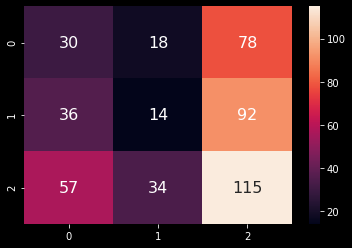

(None, Counter({1.0: 206, 0.0: 142, -1.0: 126}))

In [87]:
# Without sentiment
conf_matrix = metrics.confusion_matrix(Y_test, labels_norm)
sns.heatmap(conf_matrix,annot = True, annot_kws={"size": 16},fmt='g') # font size
plt.show(),Counter(Y_test)

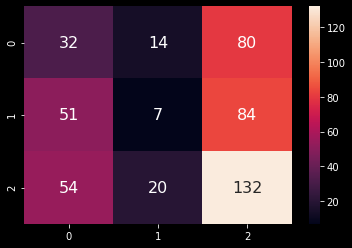

(None, Counter({1.0: 206, 0.0: 142, -1.0: 126}))

In [88]:
# With sentiment
conf_matrix = metrics.confusion_matrix(Y_test, labels_sentiment)
sns.heatmap(conf_matrix,annot = True, annot_kws={"size": 16},fmt='g') # font size
plt.show(),Counter(Y_test)

In [139]:
# sentiment metrics
from sklearn.metrics import f1_score, precision_score, recall_score
print("precision score: ", precision_score(Y_test, labels_sentiment, average="weighted"))
print("recall score: ", recall_score(Y_test, labels_sentiment, average="weighted"))
print("f1 score: ", f1_score(Y_test, labels_sentiment, average="weighted"))
print("accuracy score: ", metrics.accuracy_score(Y_test, labels_sentiment))

precision score:  0.30704519881475917
recall score:  0.36075949367088606
f1 score:  0.3161595913310098
accuracy score:  0.36075949367088606


In [140]:
# without sentiment metrics

In [141]:
from sklearn.metrics import f1_score, precision_score, recall_score
print("precision score: ", precision_score(Y_test, labels_norm, average="weighted"))
print("recall score: ", recall_score(Y_test, labels_norm, average="weighted"))
print("f1 score: ", f1_score(Y_test, labels_norm, average="weighted"))
print("accuracy score: ", metrics.accuracy_score(Y_test, labels_norm))

precision score:  0.3037462583456311
recall score:  0.33544303797468356
f1 score:  0.30796155149514864
accuracy score:  0.33544303797468356


# Backtester Without Sentiment

In [121]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
trading_data = data.iloc[len(X_train):,:]
trading_data['5_day_return'] = ((trading_data.returns + 1).rolling(5, min_periods = 5).agg(lambda x : x.prod()) - 1).shift(-5)

trading_data['predictions'] = labels_norm
trading_data.dropna(inplace=True)

<ipython-input-121-fbc364d87837>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_data['5_day_return'] = ((trading_data.returns + 1).rolling(5, min_periods = 5).agg(lambda x : x.prod()) - 1).shift(-5)
<ipython-input-121-fbc364d87837>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_data['predictions'] = labels_norm
<ipython-input-121-fbc364d87837>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

In [122]:
class Backtester:
    
    def __init__(self,trading_data, budget = 10000, investment_proportion = 0.5):
        self.trading_data = trading_data
        self.predictions  = trading_data.predictions
        self.balance      = budget
        self.dates        = trading_data.Date
        self.traded_days  = [0]
        self.drawdowns    = {'Date':[], 'Prediction':[], 'Next_5_day_return':[], 'Loss':[]}
        self.balance_hist = [self.balance]
        self.returns      = [0]
        self.investment_proportion = investment_proportion
        
    def make_money(self):
        for trading_day in self.dates:
            pred  = self.trading_data.loc[self.trading_data.Date == trading_day, 'predictions'].values[0]
            
            if pred != 0:
                profit= self.invest(pred, trading_day)
                self.traded_days.append(trading_day)
                print('On '+trading_day+' predicted '+str(pred)+' \n Profit = '+str(profit)+'$.')
                
                self.update_balance(profit)
                print("Balance: " +str(self.balance)+'$')

        
    def invest(self, pred, date):
        
        portfolio_profit = 0
        money_to_invest  = self.balance*self.investment_proportion
        investment_value = 0
        returns = self.trading_data.loc[(self.trading_data.Date >= date),'5_day_return'].values[0]
        if pred == 1:
            investment_value = money_to_invest*(1+returns)
        elif pred == -1:
            investment_value = money_to_invest*(1-returns)
            
        profit = investment_value - money_to_invest
        
        if profit<0:
            self.drawdowns['Date'].append(date)
            self.drawdowns['Prediction'].append(pred)
            self.drawdowns['Next_5_day_return'].append(returns)
            self.drawdowns['Loss'].append(profit)

        portfolio_profit = portfolio_profit+profit
                
        return portfolio_profit
        
    def update_balance(self,val1):
        new_balance    = self.balance + val1
        overall_return = (new_balance-self.balance)/self.balance
        
        self.returns.append(overall_return)
        self.balance   = new_balance
        self.balance_hist.append(self.balance)
        
    def show_drawdowns(self):
        print(tabulate(self.drawdowns, headers='keys', floatfmt='.3f', tablefmt='fancy_grid'))
    
    def show_balance_hist(self):
        hist = pd.DataFrame()
        hist['Date'] = self.traded_days
        hist['Balance'] = self.balance_hist
        hist.plot(x = 'Date', y = 'Balance', kind = 'line', figsize=(10, 7))
        plt.show()
        
    def show_returns_hist(self):
        hist = pd.DataFrame()
        hist['Date'] = self.traded_days
        hist['Returns'] = self.returns
        hist.plot(x = 'Date', y = 'Returns', kind = 'line', figsize=(10, 7))
        plt.show()
                    
                    

In [123]:
bc = Backtester(trading_data, investment_proportion = 0.4)
bc.make_money()

On 2020-01-02 predicted -1 
 Profit = -674.6702121612279$.
Balance: 9325.329787838771$
On 2020-01-03 predicted -1 
 Profit = -373.26208502093914$.
Balance: 8952.067702817832$
On 2020-01-04 predicted -1 
 Profit = -226.33776852920028$.
Balance: 8725.729934288633$
On 2020-01-05 predicted -1 
 Profit = -355.6718543973893$.
Balance: 8370.058079891243$
On 2020-01-06 predicted -1 
 Profit = -115.62759079401667$.
Balance: 8254.430489097227$
On 2020-01-11 predicted -1 
 Profit = -281.90677860402684$.
Balance: 7972.5237104932$
On 2020-01-12 predicted -1 
 Profit = -286.70702544394817$.
Balance: 7685.816685049253$
On 2020-01-13 predicted 1 
 Profit = 301.46642065858623$.
Balance: 7987.283105707838$
On 2020-01-15 predicted -1 
 Profit = 54.18618633713004$.
Balance: 8041.469292044969$
On 2020-01-16 predicted 1 
 Profit = 8.151690144755321$.
Balance: 8049.620982189725$
On 2020-01-17 predicted -1 
 Profit = 89.48829203552987$.
Balance: 8139.109274225255$
On 2020-01-18 predicted 1 
 Profit = -195.238

Balance: 30596.122859982916$
On 2021-05-04 predicted -1 
 Profit = -1124.122614650265$.
Balance: 29472.000245332652$
On 2021-05-05 predicted 1 
 Profit = -321.12300693892576$.
Balance: 29150.877238393725$
On 2021-05-06 predicted 1 
 Profit = 63.69314243198278$.
Balance: 29214.57038082571$
On 2021-05-08 predicted -1 
 Profit = 1805.9378561645517$.
Balance: 31020.50823699026$
On 2021-05-09 predicted -1 
 Profit = 1779.6063426559613$.
Balance: 32800.11457964622$
On 2021-05-10 predicted -1 
 Profit = 2137.2668489856405$.
Balance: 34937.38142863187$
On 2021-05-11 predicted -1 
 Profit = 2525.7666027792475$.
Balance: 37463.14803141111$
On 2021-05-17 predicted -1 
 Profit = 2065.4539581869685$.
Balance: 39528.60198959808$
On 2021-05-18 predicted -1 
 Profit = 2999.027450797559$.
Balance: 42527.62944039564$
On 2021-05-20 predicted -1 
 Profit = 992.9464341460007$.
Balance: 43520.57587454164$
On 2021-05-21 predicted -1 
 Profit = -928.4036132220572$.
Balance: 42592.17226131958$
On 2021-05-22 pr

In [124]:
from tabulate import tabulate
bc.show_drawdowns()

╒════════════╤══════════════╤═════════════════════╤═══════════╕
│ Date       │   Prediction │   Next_5_day_return │      Loss │
╞════════════╪══════════════╪═════════════════════╪═══════════╡
│ 2020-01-02 │       -1.000 │               0.169 │  -674.670 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-03 │       -1.000 │               0.100 │  -373.262 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-04 │       -1.000 │               0.063 │  -226.338 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-05 │       -1.000 │               0.102 │  -355.672 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-06 │       -1.000 │               0.035 │  -115.628 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-11 │       -1.000 │               0.085 │  -281.907 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-12 │       -1.000 │           

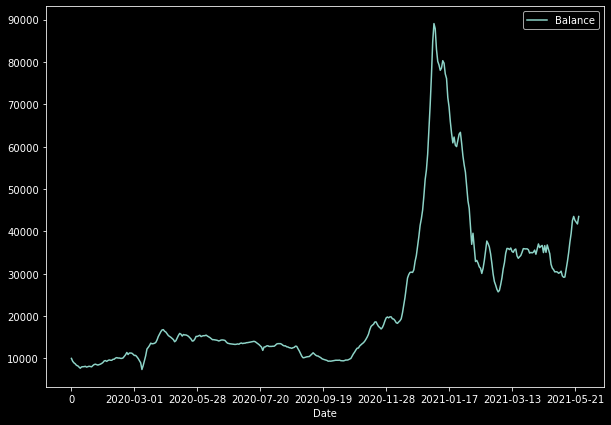

In [125]:
bc.show_balance_hist()

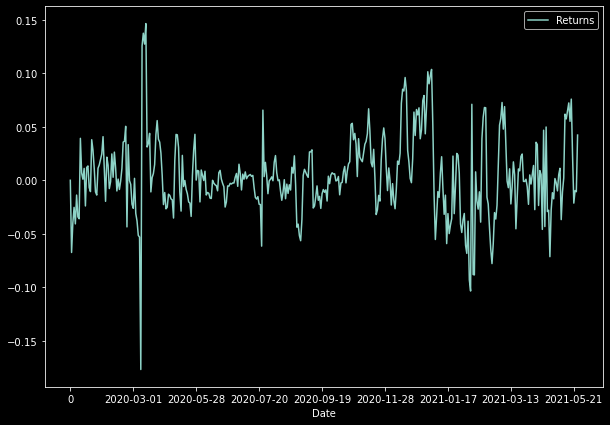

In [126]:
bc.show_returns_hist()

# Backtester With Sentiment

In [127]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,shuffle = False)
trading_data = data.iloc[len(X_train):,:]
trading_data['5_day_return'] = ((trading_data.returns + 1).rolling(5, min_periods = 5).agg(lambda x : x.prod()) - 1).shift(-5)

trading_data['predictions'] = labels_sentiment
trading_data.dropna(inplace=True)

<ipython-input-127-c35a7a429394>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_data['5_day_return'] = ((trading_data.returns + 1).rolling(5, min_periods = 5).agg(lambda x : x.prod()) - 1).shift(-5)
<ipython-input-127-c35a7a429394>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_data['predictions'] = labels_sentiment
<ipython-input-127-c35a7a429394>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [128]:
class Backtester:
    
    def __init__(self,trading_data, budget = 10000, investment_proportion = 0.5):
        self.trading_data = trading_data
        self.predictions  = trading_data.predictions
        self.balance      = budget
        self.dates        = trading_data.Date
        self.traded_days  = [0]
        self.drawdowns    = {'Date':[], 'Prediction':[], 'Next_5_day_return':[], 'Loss':[]}
        self.balance_hist = [self.balance]
        self.returns      = [0]
        self.investment_proportion = investment_proportion
        
    def make_money(self):
        for trading_day in self.dates:
            pred  = self.trading_data.loc[self.trading_data.Date == trading_day, 'predictions'].values[0]
            
            if pred != 0:
                profit= self.invest(pred, trading_day)
                self.traded_days.append(trading_day)
                print('On '+trading_day+' predicted '+str(pred)+' \n Profit = '+str(profit)+'$.')
                
                self.update_balance(profit)
                print("Balance: " +str(self.balance)+'$')

        
    def invest(self, pred, date):
        
        portfolio_profit = 0
        money_to_invest  = self.balance*self.investment_proportion
        investment_value = 0
        returns = self.trading_data.loc[(self.trading_data.Date >= date),'5_day_return'].values[0]
        if pred == 1:
            investment_value = money_to_invest*(1+returns)
        elif pred == -1:
            investment_value = money_to_invest*(1-returns)
            
        profit = investment_value - money_to_invest
        
        if profit<0:
            self.drawdowns['Date'].append(date)
            self.drawdowns['Prediction'].append(pred)
            self.drawdowns['Next_5_day_return'].append(returns)
            self.drawdowns['Loss'].append(profit)

        portfolio_profit = portfolio_profit+profit
                
        return portfolio_profit
        
    def update_balance(self,val1):
        new_balance    = self.balance + val1
        overall_return = (new_balance-self.balance)/self.balance
        
        self.returns.append(overall_return)
        self.balance   = new_balance
        self.balance_hist.append(self.balance)
        
    def show_drawdowns(self):
        print(tabulate(self.drawdowns, headers='keys', floatfmt='.3f', tablefmt='fancy_grid'))
    
    def show_balance_hist(self):
        hist = pd.DataFrame()
        hist['Date'] = self.traded_days
        hist['Balance'] = self.balance_hist
        hist.plot(x = 'Date', y = 'Balance', kind = 'line', figsize=(10, 7))
        plt.show()
        
    def show_returns_hist(self):
        hist = pd.DataFrame()
        hist['Date'] = self.traded_days
        hist['Returns'] = self.returns
        hist.plot(x = 'Date', y = 'Returns', kind = 'line', figsize=(10, 7))
        plt.show()
                    
                    

In [129]:
bc = Backtester(trading_data, investment_proportion = 0.4)
bc.make_money()

On 2020-01-02 predicted -1 
 Profit = -674.6702121612279$.
Balance: 9325.329787838771$
On 2020-01-03 predicted -1 
 Profit = -373.26208502093914$.
Balance: 8952.067702817832$
On 2020-01-04 predicted -1 
 Profit = -226.33776852920028$.
Balance: 8725.729934288633$
On 2020-01-05 predicted -1 
 Profit = -355.6718543973893$.
Balance: 8370.058079891243$
On 2020-01-07 predicted -1 
 Profit = -11.811929012170367$.
Balance: 8358.246150879073$
On 2020-01-08 predicted -1 
 Profit = -26.619208045250616$.
Balance: 8331.626942833822$
On 2020-01-09 predicted -1 
 Profit = -401.27364560678325$.
Balance: 7930.353297227039$
On 2020-01-10 predicted -1 
 Profit = -248.77305819546882$.
Balance: 7681.580239031569$
On 2020-01-11 predicted -1 
 Profit = -262.3426949483678$.
Balance: 7419.237544083202$
On 2020-01-12 predicted -1 
 Profit = -266.8098088597053$.
Balance: 7152.427735223497$
On 2020-01-13 predicted 1 
 Profit = 280.5449149667311$.
Balance: 7432.972650190228$
On 2020-01-16 predicted 1 
 Profit = 7.

Balance: 155396.6521675242$
On 2021-05-21 predicted -1 
 Profit = -3315.002397276068$.
Balance: 152081.64977024816$
On 2021-05-22 predicted -1 
 Profit = -1459.1034345412336$.
Balance: 150622.54633570692$
On 2021-05-23 predicted -1 
 Profit = -1606.307661113693$.
Balance: 149016.23867459322$
On 2021-05-24 predicted 1 
 Profit = -6298.392163543904$.
Balance: 142717.8465110493$


In [130]:
from tabulate import tabulate
bc.show_drawdowns()

╒════════════╤══════════════╤═════════════════════╤═══════════╕
│ Date       │   Prediction │   Next_5_day_return │      Loss │
╞════════════╪══════════════╪═════════════════════╪═══════════╡
│ 2020-01-02 │       -1.000 │               0.169 │  -674.670 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-03 │       -1.000 │               0.100 │  -373.262 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-04 │       -1.000 │               0.063 │  -226.338 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-05 │       -1.000 │               0.102 │  -355.672 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-07 │       -1.000 │               0.004 │   -11.812 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-08 │       -1.000 │               0.008 │   -26.619 │
├────────────┼──────────────┼─────────────────────┼───────────┤
│ 2020-01-09 │       -1.000 │           

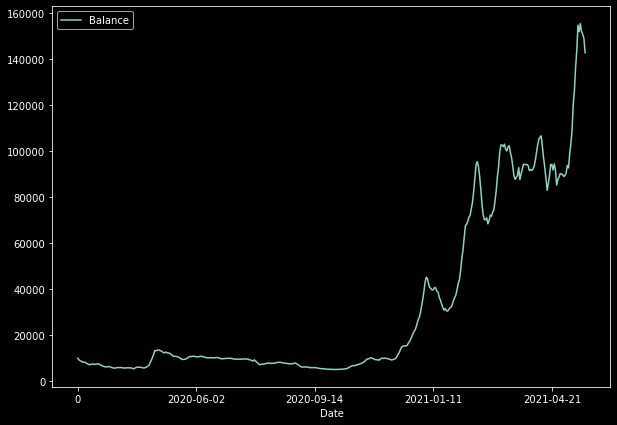

In [131]:
bc.show_balance_hist()

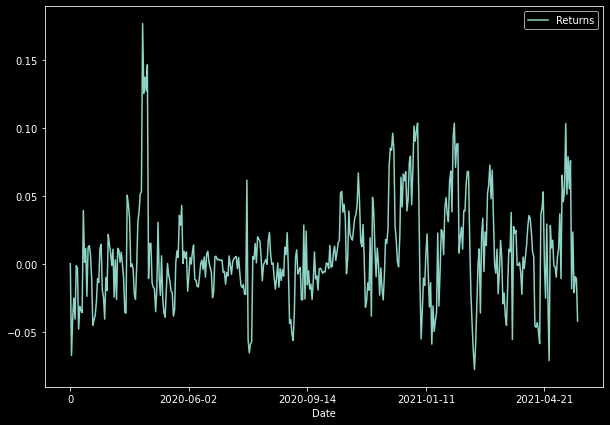

In [132]:
bc.show_returns_hist()